In [27]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
import seq2seq_model
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Bidirectional, Add, LSTM, Flatten, Dropout
from tensorflow import keras
import tensorflow as tf



In [28]:
df = pd.read_csv('2249834v2249345.csv', index_col=0)
df

,ltp odds,r1 spread,r1 pup,r2 spread,r2 pup,enhanced_markov,markov_odds,r1_0,r1_1,r1_2,r1_3,r2_0,r2_1,r2_2,r2_3
2018-07-10 12:04:50,0.867215,0.013530,0.481499,0.089986,0.500662,0.538753,0.865884,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2018-07-10 12:04:55,0.867215,0.013530,0.481499,0.089986,0.500662,0.538753,0.865884,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2018-07-10 12:05:00,0.867215,0.013530,0.481499,0.089986,0.500662,0.538753,0.865884,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2018-07-10 12:05:05,0.867215,0.013530,0.481499,0.089986,0.500662,0.538753,0.865884,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2018-07-10 12:05:10,0.867215,0.013530,0.481499,0.089986,0.500662,0.538753,0.865884,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-10 13:26:37,1.000000,0.058301,0.165943,1.288454,0.088985,1.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2018-07-10 13:26:40,1.000000,0.058301,0.165943,1.288454,0.088985,1.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2018-07-10 13:26:42,1.000000,0.058301,0.165943,1.288454,0.088985,1.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2018-07-10 13:26:45,1.000000,0.058301,0.165943,1.288454,0.088985,1.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [29]:
data = df.to_numpy()
data

array([[0.86721504, 0.01352969, 0.48149946, ..., 0.        , 0.        ,
        1.        ],
       [0.86721504, 0.01352969, 0.48149946, ..., 0.        , 0.        ,
        1.        ],
       [0.86721504, 0.01352969, 0.48149946, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [1.        , 0.05830106, 0.1659432 , ..., 0.        , 1.        ,
        0.        ],
       [1.        , 0.05830106, 0.1659432 , ..., 0.        , 1.        ,
        0.        ],
       [1.        , 0.05830106, 0.1659432 , ..., 0.        , 1.        ,
        0.        ]])

In [30]:
train_temp, test = train_test_split(data, test_size=0.6, shuffle=False)
train, val = train_test_split(train_temp, test_size=0.2, shuffle=False)
# train_x, train_y = seq2seq_model.truncate_data(data, 60 * 3, 60)
# train = data[: 60 * 8, :]
# test = data[60 * 8 :, :]
print(test.shape, train.shape)
# print(train_x[2,:,0])
# print(train_y[2,:,0])

(635, 15) (337, 15)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 75, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 75, 200)           161600    
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_10 (Dense)            (None, 16)                3216      
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 485,633
Trainable params: 485,633
Non-trainab

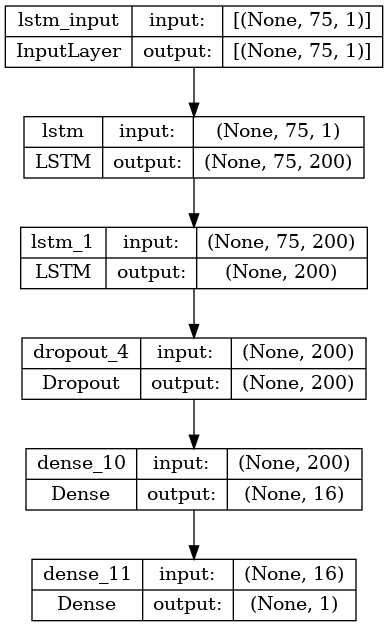

In [31]:
model = load_model("transfer_lstm_model")
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True)

In [32]:
# score, scores, actual, predicted = seq2seq_model.evaluate_model(model, train, test, 3, 36, features_out=range(1), features=range(1), features_in_num=1, features_out_num=1, initial_epochs=100, epochs=2, batches_to_train=100000)
window = 75
val_x, val_y = seq2seq_model.truncate_single_step(train, window, features_in=range(1), features_out=range(1))
results = model.evaluate(val_x, val_y)
preds = model.predict(val_x)

9/9 [==============================] - 0s 3ms/step


RMSE:  0.015067207216046484
MAE:  0.011904093436896801


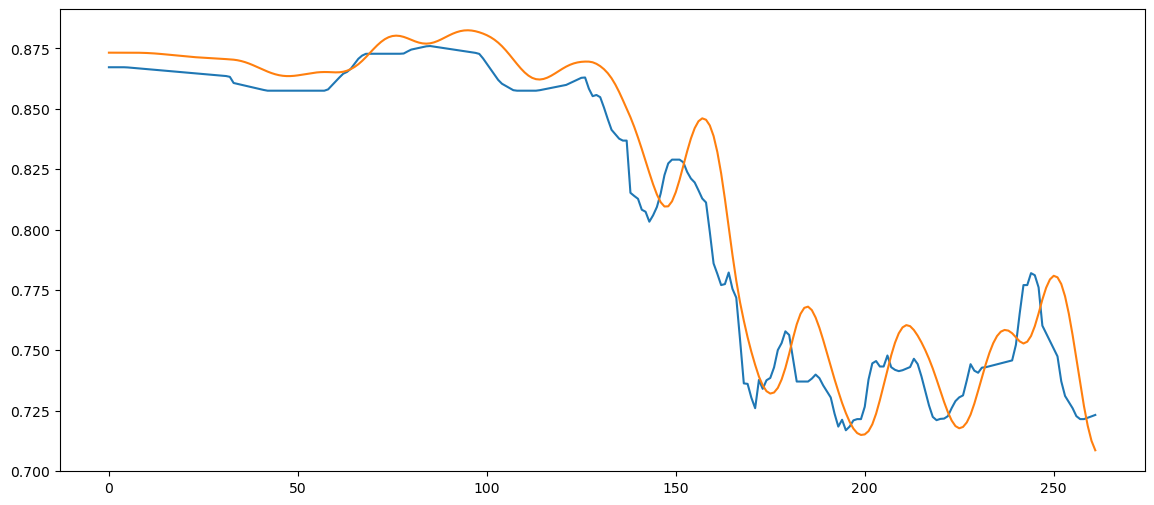

In [33]:
plt.figure(figsize=(14,6))
plt.plot(val_y[:,0])
plt.plot(preds[:,0])
print('RMSE: ', np.sqrt(results[0]))
print('MAE: ', results[1])

In [34]:
train_x, train_y = seq2seq_model.truncate_single_step(train_temp, n_steps=window, features_in=range(1), features_out=range(1))
val_x, val_y = seq2seq_model.truncate_single_step(val, window, features_in=range(1), features_out=range(1))
features_out_num = train_y.shape[1]
print(val_x.shape, val_y.shape)
print(val.shape)
print(train_x.shape, train_y.shape)
x = model.get_layer('lstm_1').output
# x = Dropout(0.2)(x)
x = Dense(16, activation='elu')(x)
x = Dense(features_out_num, activation='sigmoid')(x)
model = keras.models.Model(inputs=model.input, outputs=x)

# x = model.get_layer('bidirectional').output
# y = model.get_layer('bidirectional_1').output
# bd_out_1 = Bidirectional(LSTM(features_out_num, activation='linear'), merge_mode='sum')(x)
# bd_out_2 = Bidirectional(LSTM(features_out_num, activation='tanh'), merge_mode='sum')(y)
# model_out = Add()([bd_out_1, bd_out_2])
# model = keras.models.Model(inputs=model.input, outputs=model_out)

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mse', optimizer=opt, metrics=['mae'])
# print(model.get_layer('lstm').get_weights())
history = model.fit(train_x, train_y, epochs=25, batch_size=25, verbose=1)

(10, 75, 1) (10, 1)
(85, 15)
(347, 75, 1) (347, 1)
Epoch 1/25
14/14 [==============================] - 2s 11ms/step - loss: 0.0192 - mae: 0.1077
Epoch 2/25
14/14 [==============================] - 0s 11ms/step - loss: 0.0027 - mae: 0.0423
Epoch 3/25
14/14 [==============================] - 0s 10ms/step - loss: 0.0013 - mae: 0.0302
Epoch 4/25
14/14 [==============================] - 0s 11ms/step - loss: 9.3507e-04 - mae: 0.0249
Epoch 5/25
14/14 [==============================] - 0s 10ms/step - loss: 8.1960e-04 - mae: 0.0244
Epoch 6/25
14/14 [==============================] - 0s 10ms/step - loss: 7.2422e-04 - mae: 0.0223
Epoch 7/25
14/14 [==============================] - 0s 10ms/step - loss: 6.5961e-04 - mae: 0.0205
Epoch 8/25
14/14 [==============================] - 0s 10ms/step - loss: 6.2639e-04 - mae: 0.0194
Epoch 9/25
14/14 [==============================] - 0s 10ms/step - loss: 5.9715e-04 - mae: 0.0185
Epoch 10/25
14/14 [==============================] - 0s 10ms/step - loss: 5.664

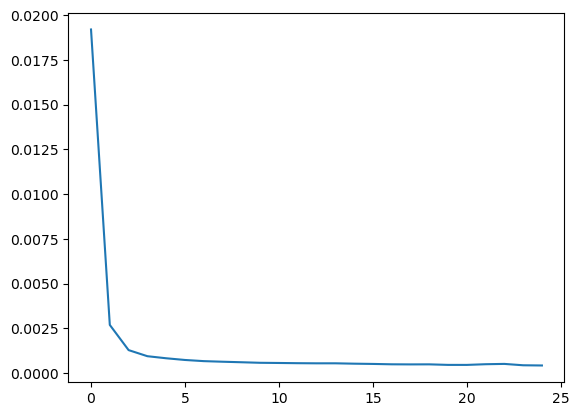

In [35]:
plt.plot(history.history['loss'])

In [36]:
test_x, test_y = seq2seq_model.truncate_single_step(test, window, features_in=range(1), features_out=range(1))
results = model.evaluate(test_x, test_y)
preds = model.predict(test_x)

18/18 [==============================] - 0s 4ms/step


(560, 1)
RMSE:  0.03602217315024003
MAE:  0.030773887410759926


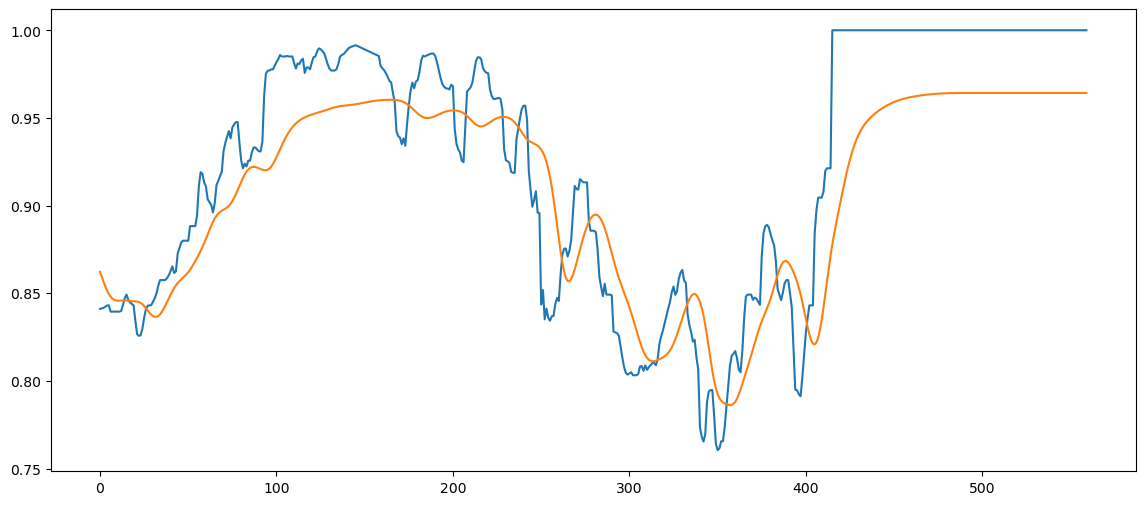

In [37]:
plt.figure(figsize=(14,6))
plt.plot(test_y[:,0])
plt.plot(preds[:,0])
print(preds.shape)
print('RMSE: ', np.sqrt(results[0]))
print('MAE: ', results[1])

In [38]:
train, test = train_test_split(data, test_size=0.6, shuffle=False)
test_x, test_y = seq2seq_model.truncate_single_step(test, window, features_in=range(1), features_out=range(1))
forecasts = []
i = 0
forecast_window = 36
while i * forecast_window < test_x.shape[0]:
    pred_x_temp = test_x[forecast_window * i, :, :]
    pred_y_temp = test_y[forecast_window * i, :]
    pred_x = pred_x_temp.reshape((1, window, pred_x_temp.shape[1]))
    y_future = []
    for k in range(forecast_window):
        pred_y = model.predict(pred_x)
        y_future.append(pred_y)
        pred_x = np.append(pred_x[:, 1:, :], pred_y.reshape(1, 1, 1), axis=1)
    forecasts.append(y_future)
    pred_x_temp = pred_x_temp.reshape((1, window, test_x.shape[2]))
    pred_y_temp = pred_y_temp.reshape((1, 1))
    train_x = np.vstack((train_x, pred_x_temp))
    train_y = np.vstack((train_y, pred_y_temp))
    i += 1
    if i % 5 == 0:
        model.reset_states()
        model.fit(train_x, train_y, epochs=3, batch_size=25, verbose=1)

1/1 [==============================] - 0s 11ms/step
Epoch 1/3
15/15 [==============================] - 0s 10ms/step - loss: 4.1386e-04 - mae: 0.0150
Epoch 2/3
15/15 [==============================] - 0s 10ms/step - loss: 4.1105e-04 - mae: 0.0152
Epoch 3/3
1/1 [==============================] - 0s 11ms/step
Epoch 1/3
15/15 [==============================] - 0s 10ms/step - loss: 4.2227e-04 - mae: 0.0152
Epoch 2/3
15/15 [==============================] - 0s 10ms/step - loss: 4.1291e-04 - mae: 0.0152
Epoch 3/3
1/1 [==============================] - 0s 10ms/step
Epoch 1/3
15/15 [==============================] - 0s 10ms/step - loss: 4.4754e-04 - mae: 0.0160
Epoch 2/3
15/15 [==============================] - 0s 10ms/step - loss: 3.9707e-04 - mae: 0.0147
Epoch 3/3
1/1 [==============================] - 0s 10ms/step


RMSE:  0.0012975969584658742
MAE:  0.030773887410759926
(16, 36, 1, 1)
(576,)


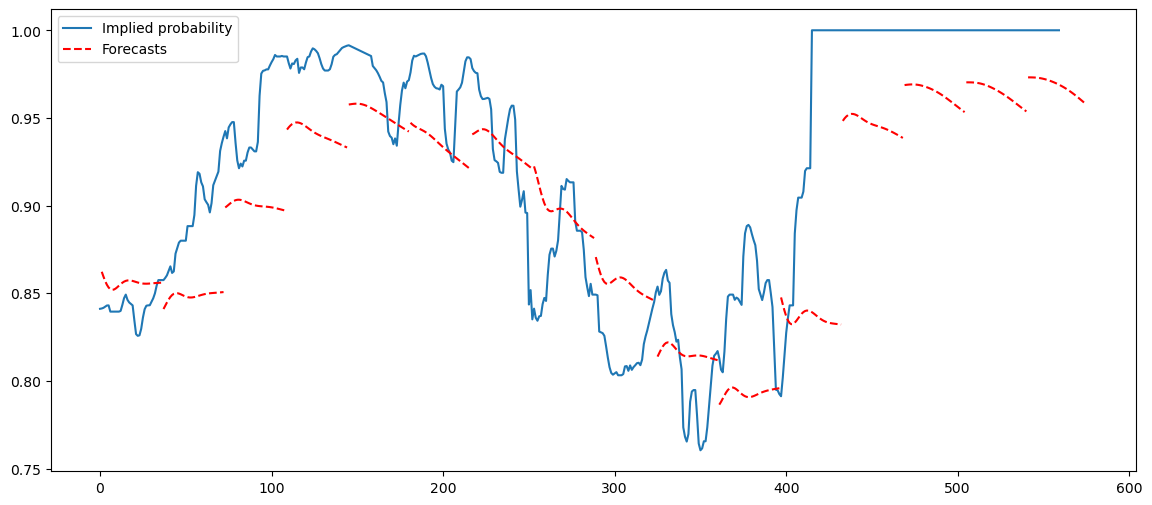

In [39]:
print('RMSE: ', results[0])
print('MAE: ', results[1])
forecasts_arr = np.array(forecasts)
forecasts_flat = forecasts_arr[:, :, 0, 0].flatten()
print(forecasts_arr.shape)
print(forecasts_flat.shape)
df_preds = pd.DataFrame({'Predictions': forecasts_flat}).shift(1)
plt.figure(figsize=(14,6))
plt.plot(test_y[:,0])
i = 0
idx = 0

while idx + forecast_window <= test_x.shape[0]:
     idx = forecast_window * i + 1
     s_pred = df_preds.iloc[idx:idx + forecast_window]
     plt.plot(s_pred, '--', color='red')
     i += 1

plt.legend(['Implied probability', 'Forecasts'])
plt.savefig('Figures/cv_forecast.png')

0           NaN
36     0.856022
72     0.850678
108    0.897152
144    0.933130
180    0.942233
216    0.920672
252    0.920967
288    0.881477
324    0.845337
360    0.811833
396    0.795832
432    0.832162
468    0.938591
504    0.953312
540    0.953720
Name: Predictions, dtype: float32
Mean absolute error of last forecast observation:  0.0519569721038256
Mean squared error of last forecast observation:  0.004519470989168709
Root mean squared error of last forecast observation:  0.06722701085998625


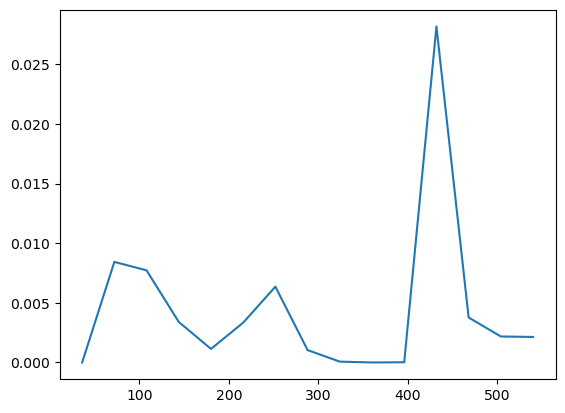

In [40]:
pred_length = test_y.shape[0]
print(df_preds['Predictions'].iloc[:pred_length:36])
df_scores = pd.DataFrame({'Forecasts': df_preds['Predictions'].iloc[:pred_length:36], 'Actual': test_y[1::36,0]})
df_scores['absolute error'] = abs(df_scores['Actual'] - df_scores['Forecasts'])
df_scores['squared error'] = df_scores['absolute error']**(2)
print('Mean absolute error of last forecast observation: ', df_scores['absolute error'].mean())
print('Mean squared error of last forecast observation: ', df_scores['squared error'].mean())
print('Root mean squared error of last forecast observation: ', np.sqrt(df_scores['squared error'].mean()))
plt.plot(df_scores['squared error'])

In [41]:
# print('RMSE: ', score)
# actual_odds = actual.reshape((actual.shape[0]*actual.shape[1]))
# predicted_odds = predicted.reshape((predicted.shape[0]*predicted.shape[1]))
# df_pred = pd.DataFrame({'pred':predicted_odds})
# plt.figure(figsize=(14,6))
# plt.plot(actual_odds)
# for i in range(predicted.shape[0]):
#     idx = 60 * i
#     s_pred = df_pred.iloc[idx:idx + 60]
#     plt.plot(s_pred, '--', color='red')

In [42]:
# plt.figure(figsize=(14,6))
# plt.plot(scores, '-o')